In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [2]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class TicTacToe:
    def __init__(self, state=None):
        # turn is X=1, 0=-1
        self.reset()
        if state is not None:
            self.state = state
        if isinstance(self.state, torch.Tensor):
            # internally state is a list (faster)
            self.state = self.state.tolist()
    
    class action_space:
        n = 9
    
    class observation_space:
        n = 11 # board, done, turn
    
    def reset(self):
        self.state = [0] * 11
        self.state[-1] = 1
        self.state[-2] = 0
        return self.state
    
    def __str__(self):
        s = str(torch.Tensor(self.state[:9]).view(3,3))
        s += '\nturn: ' + str(self.state[-1])
        return s
    
    def render(self):
        print(str(self))
        
    # 0 for draw/ongoing, 1 for Xwin, -1 for Owin
    @staticmethod
    def value(state):
        board = state[0:9]
        for turn in [1, -1]:

            for i in range(3):
                # horizontal
                if all(board[i*3 + j] == turn for j in range(3)):
                    return turn
            
                # virtical
                if all(board[j+i] == turn for j in (0,3,6)):
                    return turn
            
            # diagonals
            if all(board[i] == turn for i in (0, 4, 8)):
                return turn
            
            if all(board[i] == turn for i in (2, 4, 6)):
                return turn
        
        return 0
    
    @classmethod
    def is_done(cls, pos):
        return cls.value(pos) != 0 or all(pos[i] != 0 for i in range(9))
    
    @classmethod
    def dynamics(cls, state, act):
        state = state.copy()
        assert state[-1] in (1, -1)
        assert 0 <= act <= 8
        
        rew = 0
        if state[act] != 0:
            raise ValueError(f'illegal move, {act} occupied {state}')
            
        state[act] = state[-1]
        state[-1] *= -1
        rew = cls.value(state)
        if rew != 0 or all(state[i] != 0 for i in range(9)):
            state[-2] = 1 # done=True
            
        return rew, state

    
    def step(self, act):
        rew, self.state = TicTacToe.dynamics(self.state, act)
        
        return self.state, rew, bool(self.state[-2]), None
    
    @staticmethod
    def legal(state):
        for i in range(9):
            if state[i] == 0:
                yield i
                
        

tests = [
    (
        [[1, 1, 1],
         [0, 0, 0],
         [-1,0,-1]],
        1,
    ),
    (
        [[1, 0, 1],
         [0, 0, 0],
         [-1,-1,-1]],
        -1,
    ),
    (
        [[1, -1, 1],
         [1, 0, 0],
         [1,-1,-1]],
        1,
    ),
    (
        [[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1]],
        1,
    ),
    (
        [[0, 0, 1],
         [0, 1, 0],
         [1, 0, 1]],
        1,
    )
]

for test in tests:
    state, val = test
    tic = TicTacToe(state)
    got_val = tic.value([t for subl in state for t in subl]) # flatten
    assert got_val == val, f'want {val} got {got_val} on\n{tic}'

In [4]:
def negamax(env, obs, alpha, beta): # -> (act, val)
    turn = obs[-1]
    best_act = None
    if obs[-2]:
        # negamax relative score!
        return best_act, turn * env.value(obs)
    

    for act in env.legal(obs):
        _rew, new_obs = env.dynamics(obs, act)
        
        # beta=-alpha for child since they cannot exeed our best score or
        # we won't go down this path
        # alpha=-beta for child since their best will be our upper bound
        _act, val = negamax(env, new_obs, -beta, -alpha)
        val *= -1
        
        # if we exceed our upper bound return
        if val >= beta:
            return best_act, beta

        if val > alpha:
            best_act = act
            alpha = val
            
        
    return best_act, alpha


def search(env, obs):
    mv, val = negamax(env, obs, alpha=float('-inf'), beta=float('inf'))
    return mv, val * obs[-1]

In [5]:
env = TicTacToe()
obs = env.reset()
mv, val = search(TicTacToe, obs)
assert val == 0, val
print(mv)

0


In [6]:
#%timeit search(TicTacToe, obs)
# Was super slow earlier, got it down to ~7us, could get lower with numba jit or cython if I really cared
#%timeit env.value(obs)

In [7]:
# NERUAL NETWORK TIME FUCK YEAH

In [8]:
# 1. Become one with the dataset
def compute_label(state):
    _, val = search(TicTacToe, state.tolist())
    return val

def get_dataset(N):
    # most instructive positions are mostly empty.
    pos_dist = torch.distributions.Categorical(probs=torch.Tensor([0.2, 0.6, 0.2]))
    positions = pos_dist.sample(sample_shape=(N,9)) - 1 # minus 1 because O=-1
    
    turns = torch.randint(low=0, high=2, size=(N,))*2 - 1
    dones = torch.Tensor([1 if TicTacToe.is_done(pos) else 0 for pos in positions])

    states = torch.cat((positions, dones.view(N,1), turns.view(N,1)), dim=1)
    assert not torch.isinf(states).any()

    labels = torch.Tensor([compute_label(state) for state in states]).view(N, 1)
    assert not torch.isinf(labels).any()
    
    dataset = (states.to(device), labels.to(device))
    return dataset


def accuracy(predicted, labels):
    return (predicted.round() == labels).sum() / labels.size()[0]

N = 10000
dataset = get_dataset(N)
states, labels = dataset


In [9]:
# NOTE: having some issues with distributions and possible overfitting, its fine tho
# because I'm discontinuing this notebook for the chad mcts alphazero selfplay learner <o/
print((labels == 0).sum())
print((labels == 1).sum())
print((labels == -1).sum())

tensor(1561, device='cuda:0')
tensor(4202, device='cuda:0')
tensor(4237, device='cuda:0')


In [10]:
TicTacToe(states[0]).render()

tensor([[-1., -1., -1.],
        [-1.,  0.,  0.],
        [ 1.,  1., -1.]])
turn: -1.0


In [11]:
# 2. Super basic nerual network

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(TicTacToe.observation_space.n, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 1) # eval, tried to output moves, but was not working bc multiple best moves
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    

In [13]:
losses = []
accuracies = []

net = Net()
net.to(device)

loss_fn = nn.MSELoss()

print(net)

Net(
  (fc1): Linear(in_features=11, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)


In [14]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
batch_size = 1000

X, y = states, labels

for epoch in range(300+1):
    perm = torch.randperm(X.size()[0])
    
    for i in range(0, X.size()[0], batch_size):
        indicies = perm[i:i+batch_size]
        batch_X = X[indicies]
        batch_y = y[indicies]
        
        # Remove is_done from state, I thought the net might be abusing this to gain
        # accuracy, but removing it only incurs a 1% loss in accuracy, so I'm leaving it in.
        # batch[:,9] = 0
        output = net.forward(batch_X)

        loss = loss_fn(output, batch_y)
        losses.append(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # compute stats for this epoch over all
    
    output = net.forward(X)
    acc = accuracy(output, y)
    loss = loss_fn(output, labels)
    accuracies.append(acc)
    print(f'epoch {epoch} acc {acc} loss {loss}' + ' '*30, end='\r', flush=True)

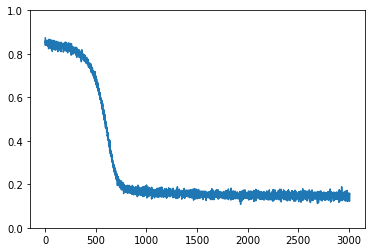

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.ylim([0, 1])
plt.plot(losses)
plt.show()

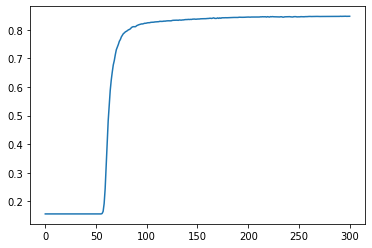

In [16]:
plt.plot(accuracies)
plt.show()

In [17]:
test_states, test_labels = get_dataset(1000)
accuracy(net.forward(test_states), test_labels)

tensor(0.8440, device='cuda:0')

In [18]:
def nn_move(tic):
    obs = tic.state
    def _value(act):
        _, new_obs = env.dynamics(obs, act)
        return net.forward(torch.Tensor(new_obs).to(device)).item()
    best = max if obs[-1] == 1.0 else min
    return best(tic.legal(obs), key=_value)

In [19]:
def tile(t):
    if t == 0.0: return '_'
    if t == 1.0: return 'X'
    if t == -1.0:return 'O'

def render(state):
    board = state[:9].reshape(3,3).tolist()
    print('\n'.join(' '.join(tile(b) for b in bob) for bob in board))
    
    print('turn', tile(state[-1].item()))


In [20]:
def agent_1(tic):
    act, val = search(tic, tic.state)
    print('negaval', val)
    return act
    
def agent_2(tic):
    act = nn_move(tic)
    print('nn', act, 'val', net.forward(torch.Tensor(tic.state).to(device)).item())
    print(tic.state)
    return act

agent = agent_1

tic = TicTacToe()
done = False

while not done:
    act = agent(tic)
    obs, rew, done, _ = tic.step(act)
    render(torch.Tensor(obs))
    #print(torch.Tensor(obs))
    agent = agent_1 if agent == agent_2 else agent_2

negaval 0
X _ _
_ _ _
_ _ _
turn O
nn 4 val 0.2226637899875641
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
X _ _
_ O _
_ _ _
turn X
negaval 0
X X _
_ O _
_ _ _
turn O
nn 2 val -0.23814783990383148
[1, 1, 0, 0, -1, 0, 0, 0, 0, 0, -1]
X X O
_ O _
_ _ _
turn X
negaval 0
X X O
_ O _
X _ _
turn O
nn 8 val -0.30334967374801636
[1, 1, -1, 0, -1, 0, 1, 0, 0, 0, -1]
X X O
_ O _
X _ O
turn X
negaval 1
X X O
X O _
X _ O
turn O
